Imports

In [1]:
import os

from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import nbinom, norm

os.chdir('/app')

from src.web_scraping.scraper import scrap_games

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Input parameters for scraping

In [2]:
years = list(range(2022, 2024))
train_year = years[0]
pred_year = years[1]

Scraping

In [33]:
scrap_games(years)

Read data

In [3]:
path = 'src/data/'
path_games = os.path.join(path, 'games/')
seasons_games = {}

# prepare dataframes - drop duplicated rows and sort by date
for year in years:
    seasons_games[year] = pd.read_csv(os.path.join(path_games, f'{year-1}_{year}_season.csv')).drop_duplicates().sort_values(by='start_time').reset_index(drop=True)

Edit dataframe

In [4]:
# get unique team names
teams = list(seasons_games[train_year]['home_team'].unique())

# map team to id
team_to_id = {team: i + 1 for i, team in enumerate(teams)}

for year in years:
    # Add IDs of teams to be differentiate for stan
    seasons_games[year]['home_team_id'] = seasons_games[year]['home_team'].map(team_to_id)
    seasons_games[year]['away_team_id'] = seasons_games[year]['away_team'].map(team_to_id)

    # Add difference in points between home team and away team
    for year in years:
        seasons_games[year]['difference'] = seasons_games[year]['home_team_score'] - seasons_games[year]['away_team_score']

Show data (first 5 rows)

In [5]:
for year in years:
    print(seasons_games[year].head())

                  start_time              away_team  away_team_score  \
0  2021-10-19 23:30:00+00:00          BROOKLYN NETS              104   
1  2021-10-20 02:00:00+00:00  GOLDEN STATE WARRIORS              121   
2  2021-10-20 23:00:00+00:00         INDIANA PACERS              122   
3  2021-10-20 23:00:00+00:00          CHICAGO BULLS               94   
4  2021-10-20 23:30:00+00:00         BOSTON CELTICS              134   

            home_team  home_team_score  home_team_id  away_team_id  difference  
0     MILWAUKEE BUCKS              127             1            28          23  
1  LOS ANGELES LAKERS              114             2            16          -7  
2   CHARLOTTE HORNETS              123             3            26           1  
3     DETROIT PISTONS               88             4            23          -6  
4     NEW YORK KNICKS              138             5            21           4  
                  start_time           away_team  away_team_score  \
0  2022-10-1

Plot data

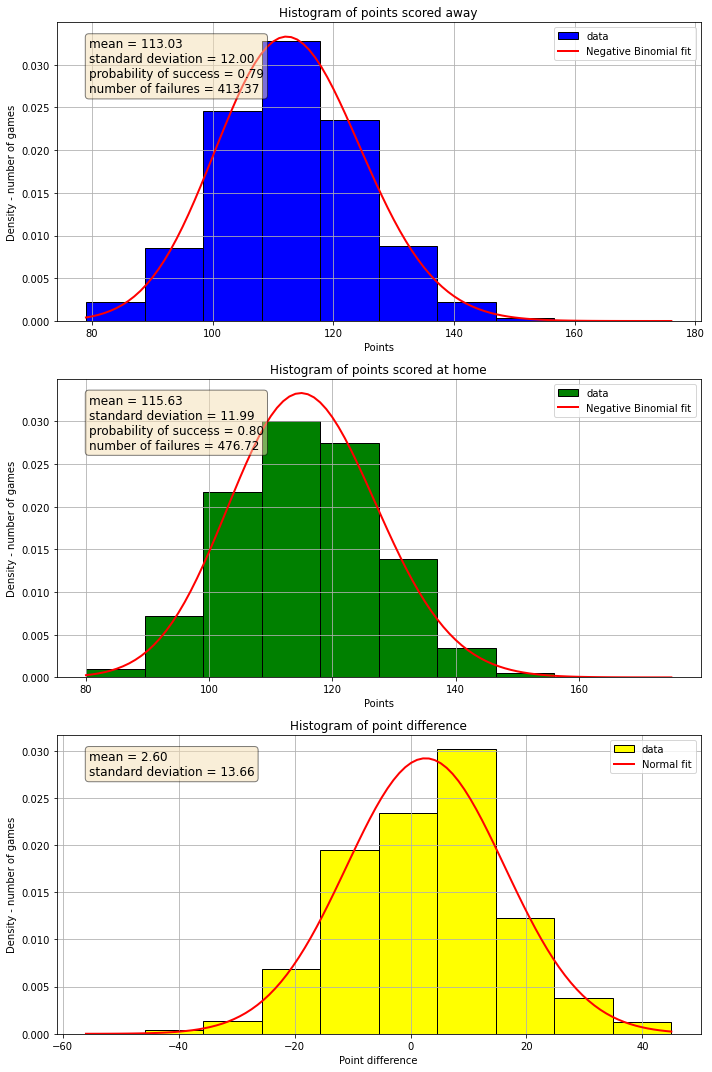

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=10, color='blue', edgecolor='black', label='data')
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=10, color='green', edgecolor='black', label='data')
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

# Histogram of point difference
axes[2].hist(seasons_games[year]['difference'], density=True, bins=10, color='yellow', edgecolor='black', label='data')
axes[2].set_title('Histogram of point difference')
axes[2].set_xlabel('Point difference')
axes[2].set_ylabel('Density - number of games')

# Plot the negative binomial PDF on each chart
for ax, col in zip(axes, ('away_team_score', 'home_team_score', 'difference')):
    mean, var = np.mean(seasons_games[year][col]), np.var(seasons_games[year][col])
    std = np.sqrt(var)
    if col == 'difference':
        x = np.linspace(min(seasons_games[year][col]), max(seasons_games[year][col]), 100)
        normal_pdf = norm.pdf(x, mean, std)
    
        # Plot the normal PDF
        ax.plot(x, normal_pdf, 'r-', lw=2, label='Normal fit')
        
        textstr = f'mean = {mean:.2f}\nstandard deviation = {std:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    else:
        p = mean / var
        r = mean ** 2 / (var - mean)  # Number of failures
        x = np.arange(min(seasons_games[year][col]), max(seasons_games[year][col]) + 1)
        nbinom_pmf = nbinom.pmf(x, r, p)
            
        # Plot the negative binomial PDF
        ax.plot(x, nbinom_pmf, 'r-', lw=2, label='Negative Binomial fit')
        
        textstr = f'mean = {mean:.2f}\nstandard deviation = {std:.2f}\nprobability of success = {p:.2f}\nnumber of failures = {r:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    ax.legend()
    ax.grid()

plt.tight_layout()

Prepare input data

In [6]:
inp_data = {
    'teams_number': len(teams),
    'games_number': len(seasons_games[train_year]),
    'home_team': seasons_games[train_year].home_team_id.to_numpy(),
    'away_team': seasons_games[train_year].away_team_id.to_numpy(),
    'home_score': seasons_games[train_year].home_team_score.to_numpy(),
    'away_score': seasons_games[train_year].away_team_score.to_numpy(),
}

Modelling

Model 1 - posterior

In [8]:
with open('src/model/model_1_posterior.stan', 'r') as f:
    print(f.read())

data {
  int teams_number;
  int games_number;
  array[games_number] int home_team;
  array[games_number] int away_team;
  array[games_number] int<lower=0> home_score;
  array[games_number] int<lower=0> away_score;
}

parameters {
  real mu_home_att;
  real mu_away_att;
  real mu_home_def;
  real mu_away_def;
  real<lower=0> sigma2_att;
  real<lower=0> sigma2_def;
  real<lower=0> phi_home;
  real<lower=0> phi_away;

  vector[teams_number-1] home_att_raw;
  vector[teams_number-1] away_att_raw;
  vector[teams_number-1] home_def_raw;
  vector[teams_number-1] away_def_raw;
}

transformed parameters {
  vector[games_number] log_mu_home;
  vector[games_number] log_mu_away;
  vector[teams_number] home_att;
  vector[teams_number] away_att;
  vector[teams_number] home_def;
  vector[teams_number] away_def;

  // need to make sum(att)=sum(def)=0
  for (k in 1:(teams_number-1)) {
    home_att[k] = home_att_raw[k];
    away_att[k] = away_att_raw[k];
    home_def[k] = home_def_raw[k];
    away_def[k

In [7]:
model_1_prior = CmdStanModel(stan_file='src/model/model_1_posterior.stan')
samples = 1000
sim=model_1_prior.sample(data=inp_data,
                     iter_sampling=samples,
                     iter_warmup=1,
                     chains=1,
                     fixed_param=False,
                     refresh=samples)

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [8]:
mod_1_post = sim.draws_pd()
mod_1_post.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu_home_att,mu_away_att,mu_home_def,...,away_def[21],away_def[22],away_def[23],away_def[24],away_def[25],away_def[26],away_def[27],away_def[28],away_def[29],away_def[30]
0,-31459.2,0.0,14.3855,0.0,1.0,1.0,31517.2,-0.303026,-1.88347,-1.50392,...,-0.643521,0.781578,-1.23274,-1.23464,-1.19475,1.31987,-0.011353,1.46224,1.10452,12.2202
1,-31459.2,0.0,14.3855,0.0,1.0,1.0,31522.5,-0.303026,-1.88347,-1.50392,...,-0.643521,0.781578,-1.23274,-1.23464,-1.19475,1.31987,-0.011353,1.46224,1.10452,12.2202
2,-31459.2,0.0,14.3855,0.0,1.0,1.0,31530.5,-0.303026,-1.88347,-1.50392,...,-0.643521,0.781578,-1.23274,-1.23464,-1.19475,1.31987,-0.011353,1.46224,1.10452,12.2202
3,-31459.2,0.0,14.3855,0.0,1.0,1.0,31517.4,-0.303026,-1.88347,-1.50392,...,-0.643521,0.781578,-1.23274,-1.23464,-1.19475,1.31987,-0.011353,1.46224,1.10452,12.2202
4,-31459.2,0.0,14.3855,0.0,1.0,1.0,31524.9,-0.303026,-1.88347,-1.50392,...,-0.643521,0.781578,-1.23274,-1.23464,-1.19475,1.31987,-0.011353,1.46224,1.10452,12.2202


/tmp/ipykernel_39697/4105485951.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


IndexError: list index out of range

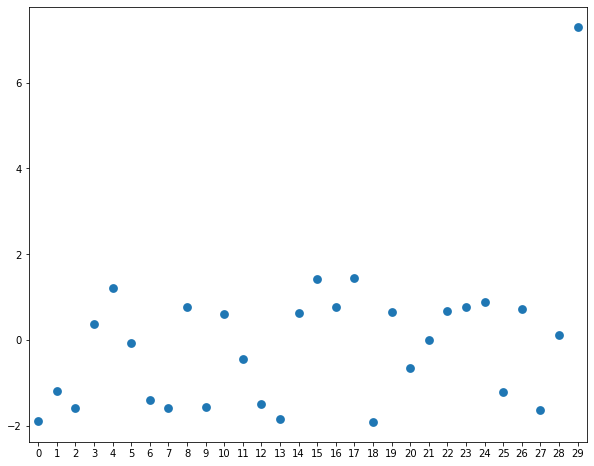

In [9]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def']
    
for param in parameters:
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)
    ax.set_xticks(range(len(teams[year])))
    ax.set_title(f'{param} Estimates')
    ax.set_xlabel('Team ID')
    plt.show()

Predicting

In [12]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def', 'phi_home', 'phi_away']
param_dict = {param: sim.stan_variable(param) for param in parameters}
# for key, val in param_dict.items():
#     print(key, val.shape)

# Extracting the samples that we need
def predict(row):
    # print(row)
    # print(type(row))
    home_idx = row['home_team_id'] - 1
    away_idx = row['away_team_id'] - 1
    home_att = param_dict['home_att'][:, home_idx]
    home_def = param_dict['home_def'][:, away_idx]
    away_att = param_dict['away_att'][:, home_idx]
    away_def = param_dict['away_def'][:, away_idx]
    size_home = param_dict['phi_home']
    size_away = param_dict['phi_away']
    # Creating the log_mu parameters
    log_mu1 = home_att + away_def
    log_mu2 = home_def + away_att
    
    # Simulating from a negative binomial distribution to obtain predictive distribution
    y1 = np.array([nbinom.rvs(n=size_home[i], p=np.exp(log_mu1[i]) / (np.exp(log_mu1[i]) + size_home[i])) for i in range(samples)])
    y2 = np.array([nbinom.rvs(n=size_away[i], p=np.exp(log_mu2[i]) / (np.exp(log_mu2[i]) + size_away[i])) for i in range(samples)])
    print(y1)
    print(y2)
    # predicted_scores = [np.bincount(y1, minlength=7), np.bincount(y2, minlength=7)]
    
    # A = np.zeros(7)
    # B = np.zeros(7)
    # for i in range(6):
    #     A[i] = predicted_scores[0][i] / np.sum(predicted_scores[0])
    #     B[i] = predicted_scores[1][i] / np.sum(predicted_scores[1])
    
    # A[6] = 1 - np.sum(A[:6])
    # B[6] = 1 - np.sum(B[:6])
    
    # name = ["0", "1", "2", "3", "4", "5", "6+"]
    # C = pd.DataFrame(index=name, columns=name)
    
    # for i in range(7):
    #     for j in range(7):
    #         C.iloc[i, j] = A[j] * B[i]
    
    # # Return predicted scores along with the home and away team for reference
    # predictions = {'HomeTeam': home_team, 'AwayTeam': away_team, 'score_probabilities': C}
    return pd.Series({
            'home_team_win_prob': [np.mean(y1 > y2)],
            'away_team_win_prob': [np.mean(y1 < y2)]
    })
    
seasons_games[pred_year][['home_team_win_prob', 'away_team_win_prob']] = seasons_games[pred_year].apply(predict, axis=1)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

KeyboardInterrupt: 

In [11]:
print(seasons_games[pred_year].head())

                  start_time           away_team  away_team_score  \
0  2022-10-18 23:30:00+00:00  PHILADELPHIA 76ERS              117   
1  2022-10-19 02:00:00+00:00  LOS ANGELES LAKERS              109   
2  2022-10-19 23:00:00+00:00       ORLANDO MAGIC              109   
3  2022-10-19 23:00:00+00:00  WASHINGTON WIZARDS              114   
4  2022-10-19 23:30:00+00:00       CHICAGO BULLS              116   

               home_team  home_team_score  difference  home_team_id  \
0         BOSTON CELTICS              126           9            21   
1  GOLDEN STATE WARRIORS              123          14            16   
2        DETROIT PISTONS              113           4             4   
3         INDIANA PACERS              107          -7            26   
4             MIAMI HEAT              108          -8            15   

   away_team_id home_team_win_prob away_team_win_prob  
0            20              [0.0]              [0.0]  
1             2              [0.0]            